In [1]:
import os
import cv2 
import tifffile
import statistics
import numpy as np

from tqdm import tqdm
from glob import glob
from scipy import ndimage as ndi
from skimage.io import imsave, imread
from skimage import (
    measure,
    morphology,
    filters,
    exposure,
    feature,
    img_as_uint,
    img_as_ubyte,
)

from commons import (rescale_arr, 
                     check_colision_border, 
                     smoothing_mask_edges, 
                     find_bighest_cluster,
                     binarize_image,
                     auto_invert_image_mask,
                     plot)

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
def _smoothing_edges(mask):

    mask = binarize_image(mask)

    mask = morphology.closing(mask, morphology.disk(9))

    mask = ndi.binary_fill_holes(mask)

    mask = filters.gaussian(mask, sigma=0.5)

    mask = binarize_image(mask)

    return find_bighest_cluster(mask)

In [4]:
def make_mask(image):
    def apply_thresh(image, block_size=1, thresh_type=199):
        return cv2.adaptiveThreshold(image, 
                                     255,
                                     cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV, 
                                     thresh_type,
                                     block_size).astype(bool)
    mask = apply_thresh(image)
    mask = auto_invert_image_mask(mask)
    
    if check_colision_border(mask):
        for block in range(1, 9):

            mask = apply_thresh(image, block)
            mask = find_bighest_cluster(mask)
            
            if not check_colision_border(mask): break

    mask = auto_invert_image_mask(mask)
    
    return _smoothing_edges(mask)

In [5]:
def apply_segment_sobel_canny(img):
    
    """
        Eu dou preferência para o sobel, caso ele não tank eu vou de canny, até dá certo xD
    """
    image_eq = exposure.equalize_hist(img)
    
    sobel_mask = filters.sobel(image_eq)
    sobel_mask = _smoothing_edges(sobel_mask)
    
    if not check_colision_border(sobel_mask):
        return sobel_mask

    for sigma in range(0, 9):

        canny_mask = feature.canny(image_eq, sigma=sigma)
        canny_mask = _smoothing_edges(canny_mask)

        if not check_colision_border(canny_mask): 
            break

    return canny_mask

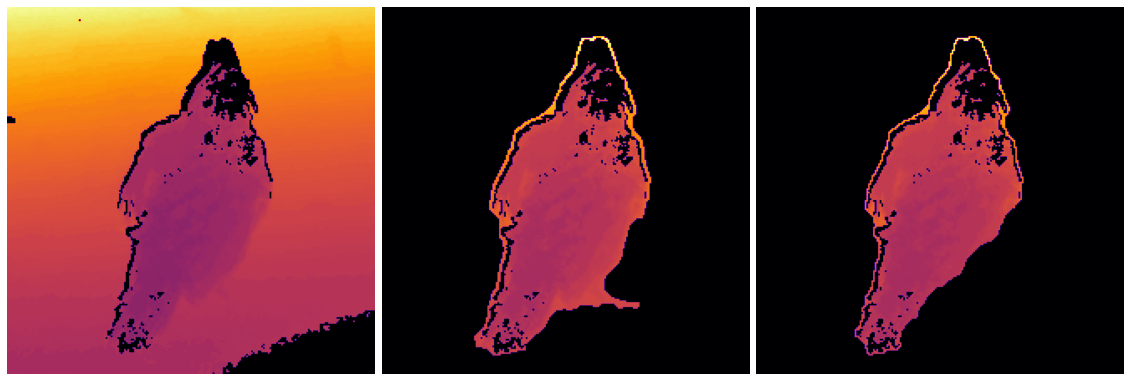

In [6]:
image = imread('segmentation_out/images/021/187.tif')

mask = apply_segment_sobel_canny(image)
maski = make_mask(image)
plot([image, (image * mask), (image * maski)], (1, 3))

In [7]:
def run_segmenter(function_run, destiny):
    
    try:
        os.makedirs(destiny)
        os.makedirs(destiny + '/masks')
    except Exception:
        pass

    path_image = 'segmentation_out/images/*'

    for path in tqdm(glob(path_image)):

        image_name = path.split('/')[2]

        try:
            os.makedirs(f'{destiny}/masks/{image_name}')
        except Exception as e:
            pass

        for path_frames in glob(path + '/*'):

            image_frame_name,_ = path_frames.split('/')[3].split('.')

            try:

                frame = imread(path_frames)
                
                """
                    Lógica de segmentação
                    Here
                """

                mask = function_run(frame).astype(bool)

                imsave(f'{destiny}/masks/{image_name}/{image_frame_name}.tif', img_as_ubyte(mask))

            except Exception as e:
                continue

In [8]:
run_segmenter(make_mask, 'mak_mask')

100%|███████████████████████████████████████████| 25/25 [05:13<00:00, 12.54s/it]


In [9]:
run_segmenter(apply_segment_sobel_canny, 'sobel_canny')

100%|███████████████████████████████████████████| 25/25 [14:45<00:00, 35.44s/it]
